# Data Loading

In [1]:
import os
import pandas as pd

In [2]:
master_folder = "../EMG_data_for_gestures-master"
cleaned_data_by_subject = {}

In [3]:
# Loop through each subject's folder
for subject_folder in sorted(os.listdir(master_folder)):
    subject_path = os.path.join(master_folder, subject_folder)

    if os.path.isdir(subject_path):  # Check if it's a directory
        subject_number = int(subject_folder)  # Convert subject folder name to an integer
        
        trials = []
        
        for file_name in sorted(os.listdir(subject_path)):
            if file_name.endswith('.txt'):
                file_path = os.path.join(subject_path, file_name)
                
                # Load the .txt file with proper handling for mixed types and whitespace delimiter
                df = pd.read_csv(file_path, delim_whitespace=True, dtype=str)  # Load as strings to avoid dtype issues

                # Drop 'time' column
                df.drop('time', inplace=True, axis=1)
                
                # Drop rows where 'class' column has NaNs or non-numeric values
                df = df[df["class"].notna() & df["class"].str.isnumeric()]
                
                # Convert 'class' column to integer
                df["class"] = df["class"].astype(int)
                
                # Keep only relevant classes (1 to 6) and drop others
                df = df[df["class"].isin([1, 2, 3, 4, 5, 6])]
                
                # Append the cleaned trial data to the list
                trials.append(df)
        
        # Concatenate trials for the current subject
        subject_data = pd.concat(trials, axis=0).reset_index(drop=True)
        
        # Store the cleaned data for the subject
        cleaned_data_by_subject[subject_number] = subject_data

print(f"Loaded and cleaned data for {len(cleaned_data_by_subject)} subjects.")

Loaded and cleaned data for 36 subjects.


In [4]:
segmented_data_by_subject = {}

# Loop through each subject's cleaned data
for subject_number, subject_data in cleaned_data_by_subject.items():
    segmented_trials = []  # Store segmented data for all trials of this subject

    # Sort trials by 'trial' column if applicable
    if 'trial' in subject_data.columns:
        trials = subject_data.groupby('trial')
    else:
        trials = [(None, subject_data)]  # Single trial case

    # Process each trial separately
    for trial_id, trial_data in trials:
        trial_segments = []  # Store all segments for this trial

        # Identify gesture segments by detecting label changes
        current_label = trial_data.iloc[0]['class']  # Start with the first label
        start_index = 0  # Index for the beginning of the segment

        for i in range(1, len(trial_data)):
            if trial_data.iloc[i]['class'] != current_label:
                # Extract the segment for the current label
                segment = trial_data.iloc[start_index:i]
                trial_segments.append(segment)

                # Update the current label and start index
                current_label = trial_data.iloc[i]['class']
                start_index = i

        # Capture the last segment
        segment = trial_data.iloc[start_index:]
        trial_segments.append(segment)

        # Add the segmented data for this trial
        segmented_trials.extend(trial_segments)

    # Store segmented data for the subject
    segmented_data_by_subject[subject_number] = segmented_trials

print(f"Segmented data for {len(segmented_data_by_subject)} subjects.")

Segmented data for 36 subjects.


# Sliding Window - 1st CNN
## New iteration

In [5]:
import numpy as np
from scipy.stats import mode

In [6]:
def extract_sliding_windows(segmented_data, window_size, stride):
    """
    Extracts sliding windows from segmented data.

    Args:
        segmented_data (dict): Segmented data by subject.
        window_size (int): Number of samples in each window.
        stride (int): Step size between consecutive windows.

    Returns:
        list: A list of tuples where each tuple is (window_data, window_label).
    """
    sliding_windows = []

    for subject, trials in segmented_data.items():
        # print(f"Processing Subject {subject}...")
        
        for segment in trials:
            segment_label = segment['class'].iloc[0]  # The class label for the entire segment
            segment_data = segment.drop(columns=['class']).values  # Drop the label column
            
            # Generate windows from this segment
            for start_idx in range(0, len(segment_data) - window_size + 1, stride):
                window = segment_data[start_idx:start_idx + window_size]
                sliding_windows.append((window, segment_label))
    
    print(f"Extracted {len(sliding_windows)} windows.")
    return sliding_windows

In [7]:
# Parameters for sliding windows
window_size = 500  # e.g., 100 samples per window
stride = 100        # e.g., 50-sample step size

# Extract sliding windows from segmented data
sliding_windows = extract_sliding_windows(segmented_data_by_subject, window_size, stride)

# Inspect the number of windows
print(f"Total sliding windows: {len(sliding_windows)}")

# Example: Shape of one window and its label
example_window, example_label = sliding_windows[0]
print(f"Window shape: {example_window.shape}, Label: {example_label}")

Extracted 11105 windows.
Total sliding windows: 11105
Window shape: (500, 8), Label: 1


In [8]:
from sklearn.model_selection import train_test_split

# Extract data and labels from sliding windows
X = np.array([window for window, _ in sliding_windows])  # Shape: (num_windows, window_size, num_channels)
y = np.array([label for _, label in sliding_windows])   # Shape: (num_windows,)

# Split into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (7773, 500, 8), Validation set: (1666, 500, 8), Test set: (1666, 500, 8)


In [9]:
# Convert training and testing data to float
X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

In [10]:
# Zero-index the class labels by subtracting 1
y_train -= 1
y_val -= 1
y_test -= 1

print("Class labels have been zero-indexed.")

Class labels have been zero-indexed.


In [11]:
# Standardize features across the entire training set (per channel)
mean = X_train.mean(axis=(0, 1))  # Mean for each channel
std = X_train.std(axis=(0, 1))    # Std for each channel

# Apply standardization
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

print("Data standardized.")

Data standardized.


In [12]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print("Labels converted to one-hot encoding.")

Labels converted to one-hot encoding.


In [13]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model parameters
input_shape = (X_train.shape[1], X_train.shape[2])  # (window_size, num_channels)
num_classes = y_train.shape[1]  # Number of gesture classes
regularization_strength = 0.001  # Strength of L2 regularization (adjust if needed)

# Build the CNN model with L2 regularization
model = Sequential([
    # First convolutional layer
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape,
           kernel_regularizer=l2(regularization_strength)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    # Second convolutional layer
    Conv1D(filters=64, kernel_size=3, activation='relu',
           kernel_regularizer=l2(regularization_strength)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    # Flatten and fully connected layers
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(regularization_strength)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax', kernel_regularizer=l2(regularization_strength))  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 498, 32)           800       
                                                                 
 max_pooling1d (MaxPooling1  (None, 249, 32)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 249, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 247, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 123, 64)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 123, 64)           0

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Number of epochs
    batch_size=32,  # Mini-batch size
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100
243/243 [==============================] - 3s 9ms/step - loss: 1.3849 - accuracy: 0.4701 - val_loss: 0.9075 - val_accuracy: 0.6717
Epoch 2/100
243/243 [==============================] - 2s 8ms/step - loss: 0.9603 - accuracy: 0.6350 - val_loss: 0.7044 - val_accuracy: 0.8001
Epoch 3/100
243/243 [==============================] - 2s 9ms/step - loss: 0.7506 - accuracy: 0.7516 - val_loss: 0.5850 - val_accuracy: 0.8187
Epoch 4/100
243/243 [==============================] - 2s 9ms/step - loss: 0.6501 - accuracy: 0.7935 - val_loss: 0.5319 - val_accuracy: 0.8367
Epoch 5/100
243/243 [==============================] - 2s 8ms/step - loss: 0.6021 - accuracy: 0.8147 - val_loss: 0.5013 - val_accuracy: 0.8571
Epoch 6/100
243/243 [==============================] - 2s 8ms/step - loss: 0.5542 - accuracy: 0.8356 - val_loss: 0.4913 - val_accuracy: 0.8553
Epoch 7/100
243/243 [==============================] - 2s 8ms/step - loss: 0.5239 - accuracy: 0.8524 - val_loss: 0.4820 - val_accuracy: 0.8667

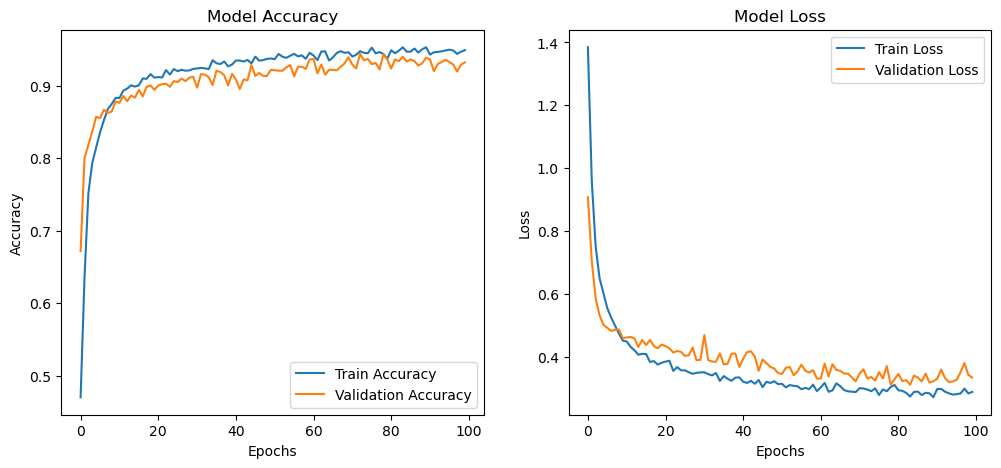

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print performance metrics
print("Model Performance:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Optional: Evaluate on validation set for comparison
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Model Performance:
Test Loss: 0.3396
Test Accuracy: 0.9340
Validation Loss: 0.3333
Validation Accuracy: 0.9322
